# Generating a GLM using Inspect API

This notebook will go through the process of generating a Generalised Linear Model using the Inspect API. It will show the power of linked data where data from different domains (economics, demography) will be merged together using linked data.

### Import packages

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import seaborn as sns; sns.set()

## Using the Inspect command

By providing the file path to the metadata JSON file and using the inspector object we can explore the metadata and so treat the data correctly as the metadata is respected and machine readable.



In [4]:
from csvcubed.inspect.inspectortable import Inspector

median_pay = Inspector("/Users/abdulkasim/Desktop/family-ess/out/gross-median-weekly-pay/gross-median-weekly-pay/gross-median-weekly-pay.csv-metadata.json")
qualifications = Inspector("/Users/abdulkasim/Desktop/family-ess/out/aged-16-to-64-years-level-3-or-above-qualifications/aged-16-to-64-years-level-3-or-above-qualifications/aged-16-to-64-years-level-3-or-above-qualifications.csv-metadata.json")
cigarette = Inspector("/Users/abdulkasim/Desktop/family-ess/out/cigarette-smokers/cigarette-smokers/cigarette-smokers.csv-metadata.json")
employment_rate = Inspector("/Users/abdulkasim/Desktop/family-ess/out/employment-rate-for-16-to-64-year-olds/employment-rate-for-16-to-64-year-olds/employment-rate-for-16-to-64-year-olds.csv-metadata.json")
children_literacy = Inspector("/Users/abdulkasim/Desktop/family-ess/out/children-at-expected-level-for-literacy-by-end-of-early-years-foundation-stage/children-at-expected-level-for-literacy-by-end-of-early-years-foundation-stage/children-at-expected-level-for-literacy-by-end-of-early-years-foundation-stage.csv-metadata.json")
apprenticeship_starts = Inspector("/Users/abdulkasim/Desktop/family-ess/out/apprenticeships-starts/apprenticeships-starts/apprenticeships-starts.csv-metadata.json")
gcses = Inspector("/Users/abdulkasim/Desktop/family-ess/out/gcses-and-equivalent-in-english-and-maths-by-age-19/gcses-and-equivalent-in-english-and-maths-by-age-19/gcses-and-equivalent-in-english-and-maths-by-age-19.csv-metadata.json")
reception_children_overweight = Inspector("/Users/abdulkasim/Desktop/family-ess/out/overweight-children-at-reception-age-aged-four-to-five-years/overweight-children-at-reception-age-aged-four-to-five-years/overweight-children-at-reception-age-aged-four-to-five-years.csv-metadata.json")
year6_children_overweight = Inspector("/Users/abdulkasim/Desktop/family-ess/out/overweight-children-at-year-6-age-aged-10-to-11-years/overweight-children-at-year-6-age-aged-10-to-11-years/overweight-children-at-year-6-age-aged-10-to-11-years.csv-metadata.json")

## Load the CSV-W into a pandas DataFrame

In [5]:
median_pay_df, errors = median_pay.tables[0].data_cube_repository.get_dataframe(median_pay.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False)
qualifications_df, errors = qualifications.tables[0].data_cube_repository.get_dataframe(qualifications.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False)
cigarette_df, errors = cigarette.tables[0].data_cube_repository.get_dataframe(cigarette.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False)
employment_rate_df, errors = employment_rate.tables[0].data_cube_repository.get_dataframe(employment_rate.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False)
children_literacy_df, errors = children_literacy.tables[0].data_cube_repository.get_dataframe(children_literacy.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False)
apprenticeship_starts_df, errors = apprenticeship_starts.tables[0].data_cube_repository.get_dataframe(apprenticeship_starts.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False) 
gcses_df, errors = gcses.tables[0].data_cube_repository.get_dataframe(gcses.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False) 
reception_children_overweight_df, errors = reception_children_overweight.tables[0].data_cube_repository.get_dataframe(reception_children_overweight.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False) 
year6_children_overweight_df, errors = year6_children_overweight.tables[0].data_cube_repository.get_dataframe(year6_children_overweight.tables[0].csv_url, include_suppressed_cols=True, dereference_uris=False) 

## Data transformations


Now that we have loaded a dataframe for each of the datasets. We now want to merge them together to then be able to generate a GLM.

Before we get to generating a GLM we will need to make some transformations to each dataset.

For each dataset the following changes need to be made:
* Only return values for the most recent year
* Using the features of the Inspect API rename the value column to the measure label, so that after joining all datasets it is easily identifiable which column belongs to which dataset
* Merge all datasets together

In [6]:
csvws = [median_pay, qualifications, cigarette, employment_rate, children_literacy, apprenticeship_starts, gcses, reception_children_overweight, year6_children_overweight]
datasets = [median_pay_df, qualifications_df, cigarette_df, employment_rate_df, children_literacy_df, apprenticeship_starts_df, gcses_df, reception_children_overweight_df, year6_children_overweight_df]


modified_dataframes = []

for metadata, df in zip(csvws, datasets):
    columns = metadata.tables[0].columns
    measure_label = columns["Value"].measure.label

    df.rename(columns={"Value": f"{measure_label}"}, inplace=True)

    df["Period"] = df["Period"].astype(str).str[:4].astype(int)
    max_year = df["Period"].max()
    df = df[df["Period"] == max_year]
    df = df[['AREACD', 'AREANM', f'{measure_label}']].reset_index(drop=True)

    modified_dataframes.append(df)


## Merge all dataframes iteratively

In [7]:
df = modified_dataframes[0]
for dataset in modified_dataframes[1:]:
    df = df.merge(dataset, on=['AREACD', 'AREANM'], how='outer')

## EDA

For simplicity drop missing data.

In [8]:
df.isna().sum()

AREACD                                                                   0
AREANM                                                                   0
Gross median weekly pay                                                 31
Aged 16 to 64 years level 3 or above qualifications                     33
Cigarette smokers                                                       60
Employment rate for 16 to 64 year olds                                  57
Children at end of early years foundation stage for literacy           107
Number of apprenticeship starts                                        110
GCSEs (and equivalent) in English and maths by age 19                  110
Reception age children (aged four to five years) who are overweight     99
Year 6 children (aged 10 to 11 years) who are overweight                97
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True)

## Rename columns for pairplot visualisation

In [139]:
pairplot_df = df.copy()
pairplot_df.columns = ['AREACD', 'AREANM', 
       'median pay',
       'disposable income',
       '16 to 64 qualifications',
       'Cigarette smokers',
       'Employment rate',
       'Children for literacy',
       'apprenticeship starts',
       'GCSEs',
       'Reception children overweight',
       'Year 6 children overweight']

In [142]:
features = df.iloc[:,2:]

/Users/abdulkasim/.pyenv/versions/3.10.3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


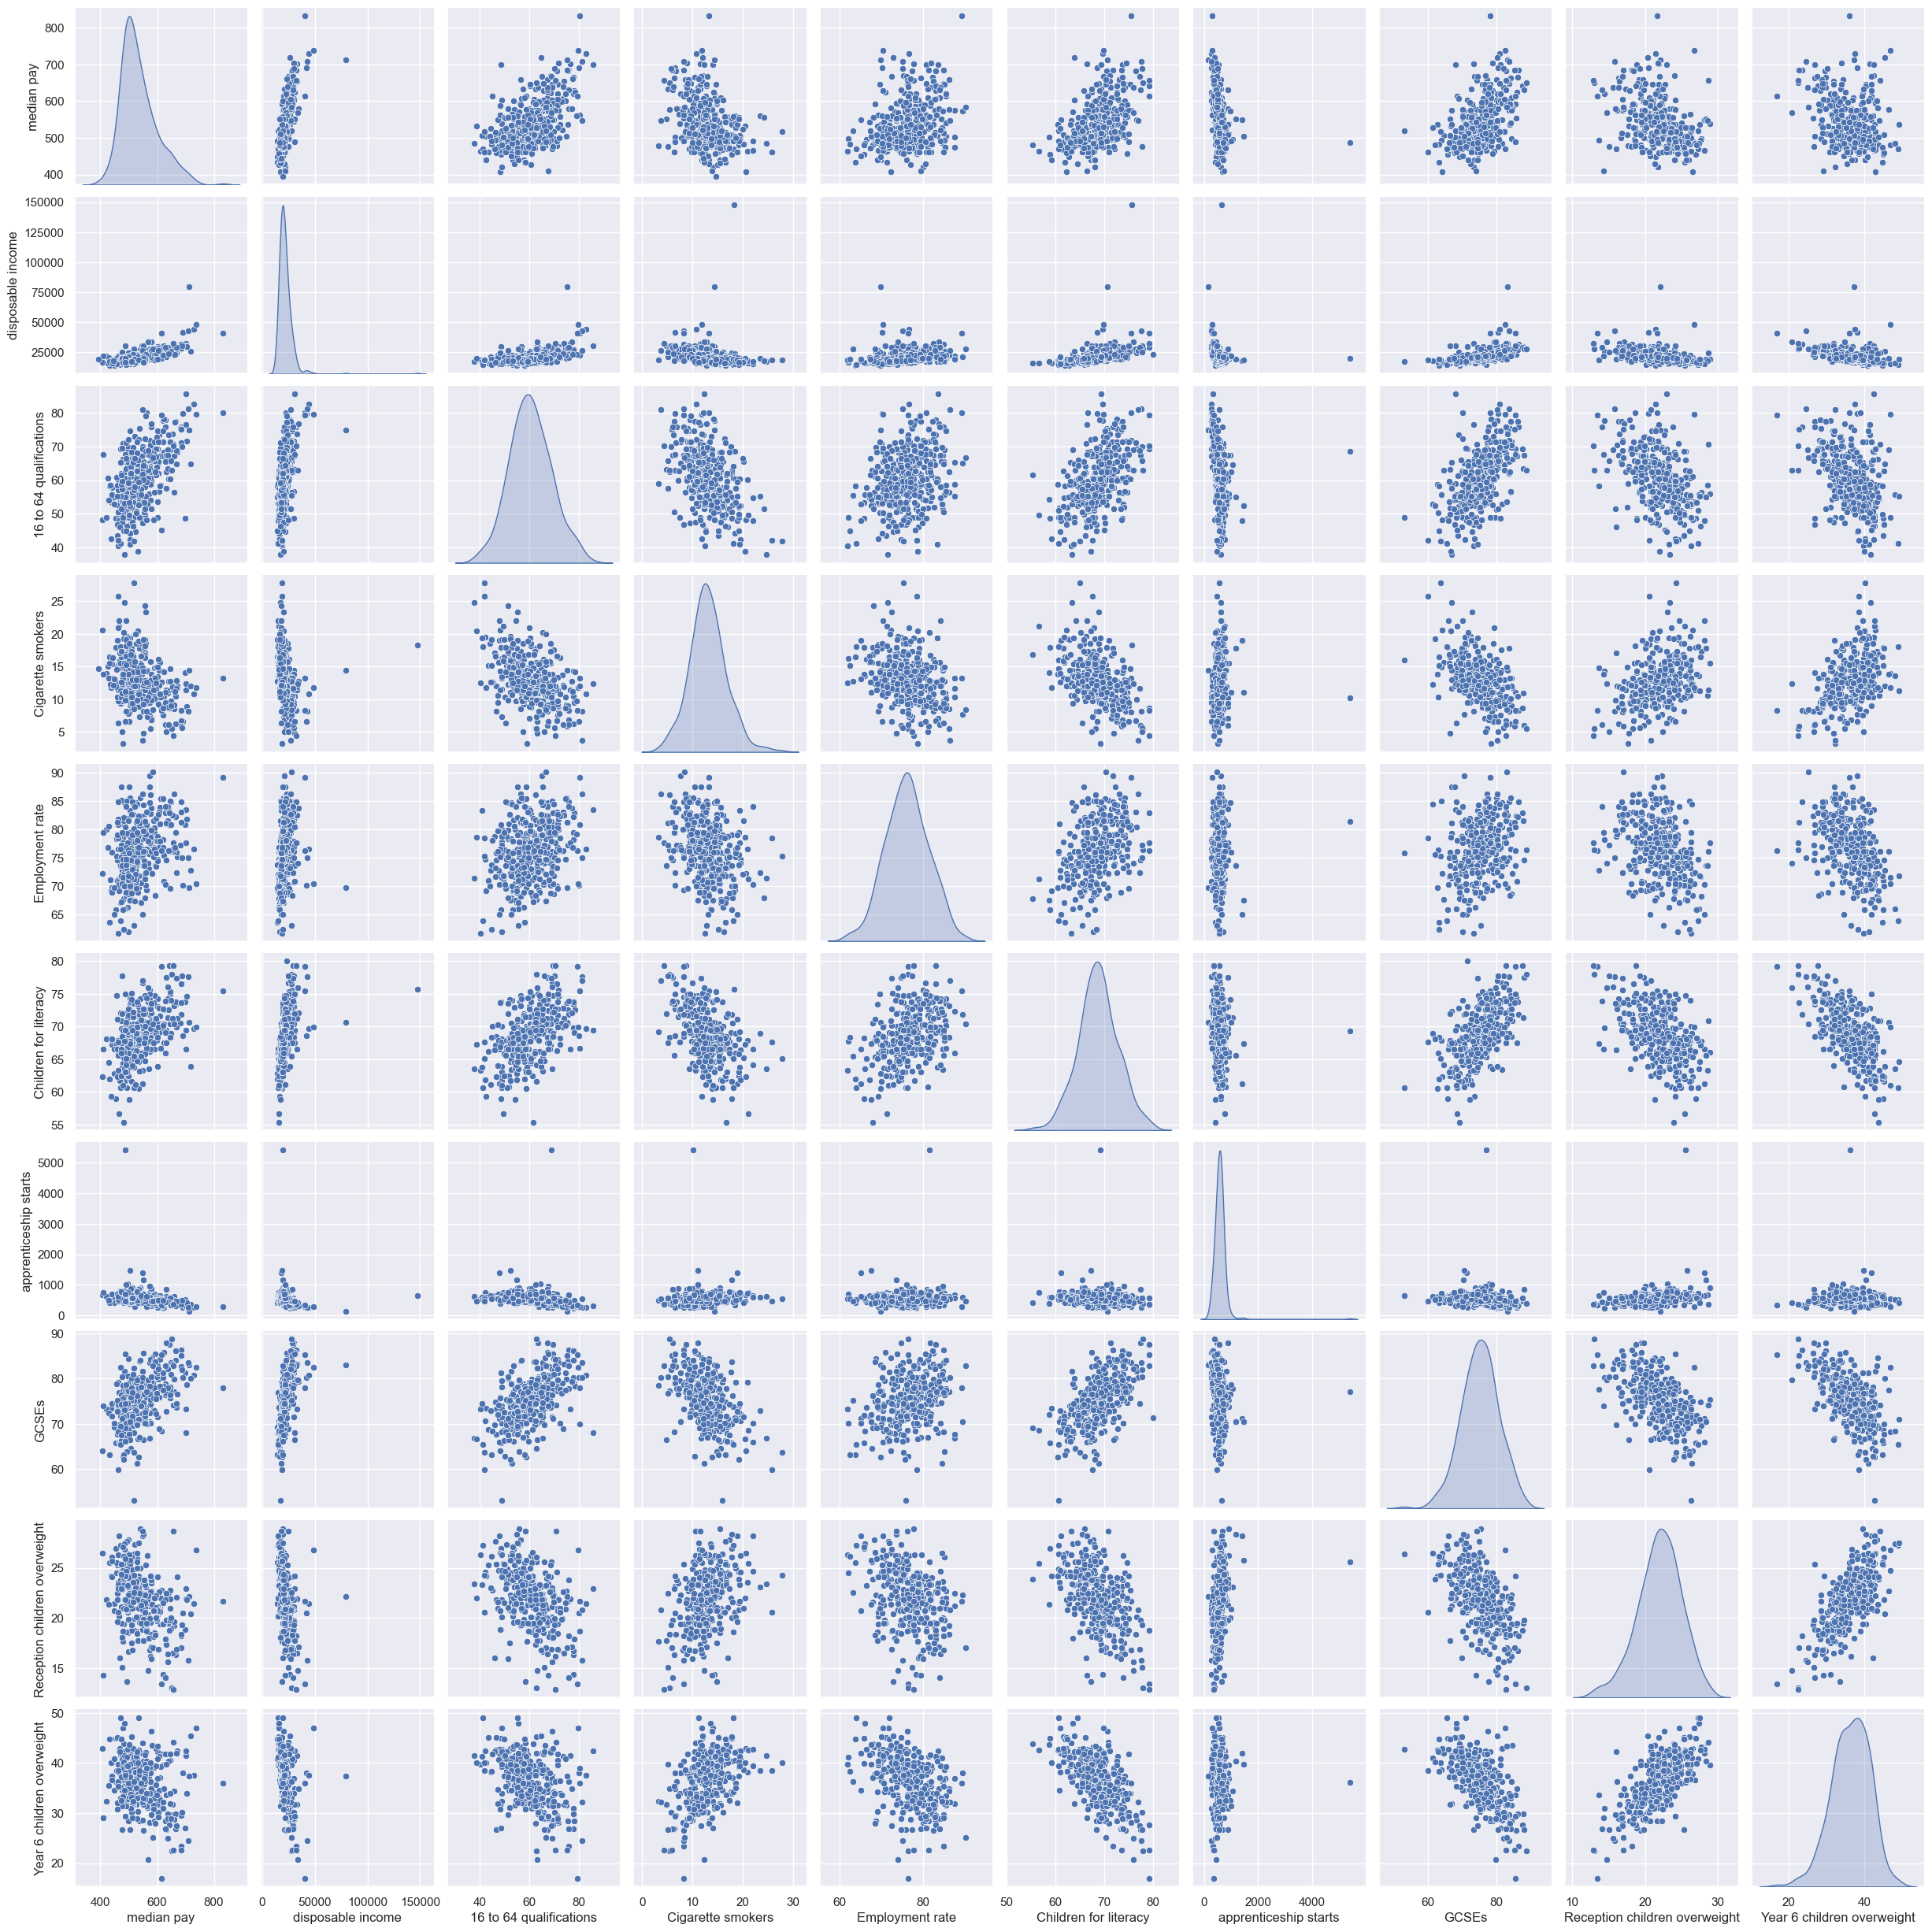

In [143]:
pairplot = sns.pairplot(data=pairplot_df, 
                        diag_kind="kde")
pairplot;

In [10]:
df.columns = df.columns.str.replace(" ", "_").str.replace("(", "").str.replace(")", "").str.lower()

from sklearn.preprocessing import StandardScaler
x = df.iloc[:, 3:].values
y = df.iloc[:, 2].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=df.columns[3:])

In [12]:
dfcols = df[["areacd", "areanm", "gross_median_weekly_pay"]]
data = pd.concat([dfcols, x], axis=1)

In [13]:
model = smf.glm(formula = "gross_median_weekly_pay ~ aged_16_to_64_years_level_3_or_above_qualifications + cigarette_smokers + employment_rate_for_16_to_64_year_olds + children_at_end_of_early_years_foundation_stage_for_literacy + number_of_apprenticeship_starts + gcses_and_equivalent_in_english_and_maths_by_age_19 + reception_age_children_aged_four_to_five_years_who_are_overweight + year_6_children_aged_10_to_11_years_who_are_overweight",
                data = data, 
                family = sm.families.Gaussian())

# Fit the model
result = model.fit()
# Display and interpret results
print(result.summary())
# Estimated default probabilities
predictions = result.predict()

                    Generalized Linear Model Regression Results                    
Dep. Variable:     gross_median_weekly_pay   No. Observations:                  313
Model:                                 GLM   Df Residuals:                      304
Model Family:                     Gaussian   Df Model:                            8
Link Function:                    Identity   Scale:                          2468.8
Method:                               IRLS   Log-Likelihood:                -1662.1
Date:                     Wed, 30 Aug 2023   Deviance:                   7.5050e+05
Time:                             15:21:32   Pearson chi2:                 7.51e+05
No. Iterations:                          3   Pseudo R-squ. (CS):             0.5965
Covariance Type:                 nonrobust                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

## Findings

We conducted a Generalized Linear Model (GLM) analysis with the help of a linked data package to collate the data together.

The GLM was conducted to explore the relationship between our dependent variable - gross median weekly pay and nine independent variables - gross_disposable_household_income_per_head, aged_16_to_64_years_level_3_or_above_qualifications, cigarette_smokers, employment_rate_for_16_to_64_year_olds, children_at_end_of_early_years_foundation_stage_for_literacy, number_of_apprenticeship_starts, gcses_and_equivalent_in_english_and_maths_by_age_19, reception_age_children_aged_four_to_five_years_who_are_overweight and, year_6_children_aged_10_to_11_years_who_are_overweight. 

The results revealed several significant relationships between the independent and dependent variables. Notably, gross_disposable_household_income_per_head and year_6_children_aged_10_to_11_years_who_are_overweight demonstrated strong positive correlations with the dependent variable, suggesting that increases in these factors are linked to higher values of gross_median_weekly_pay. 

Conversely, reception_age_children_aged_four_to_five_years_who_are_overweight and number_of_apprenticeship_starts displayed negative coefficients, implying that higher values of these predictors are associated with lower values of gross_median_weekly_pay.

It's important to note that while our model explained a substantial portion of the variance in the dependent variable (0.7925), there may still be unaccounted factors influencing the outcome. These findings provide valuable insights into the relationship between the independent and dependent variables, highlighting potential areas for further investigation.

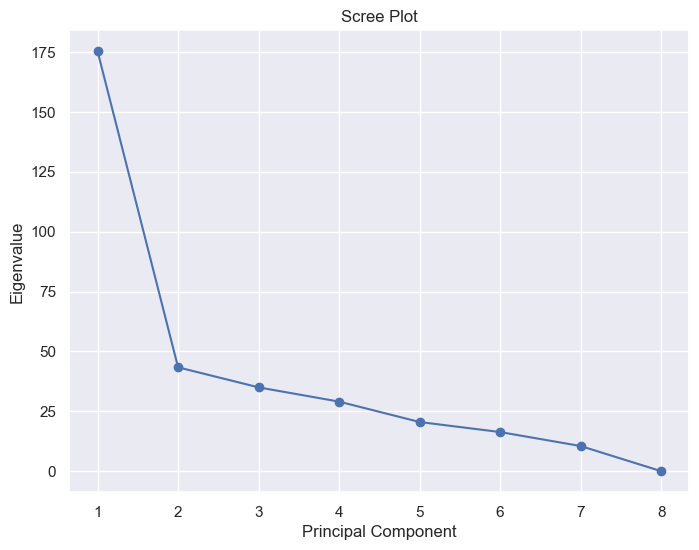

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

features = data.iloc[:, 3:].to_numpy()
combined_data = np.column_stack(features)

# Perform PCA
pca = PCA()
pca.fit(combined_data)

# Get the eigenvalues
eigenvalues = pca.explained_variance_

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(np.arange(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()